## STEP 3

In [1]:
# %load_ext autoreload
# %autoreload 2

import sys
import os

# Ajoute le dossier "src" au path
src_path = os.path.abspath("..")
if src_path not in sys.path:
    sys.path.append(src_path)
	
# Data manipulation
import pandas as pd
import numpy as np
from pandas import DataFrame

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Reducer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Preprocessing
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer
from collections import Counter
import re
import emoji
from sklearn.base import BaseEstimator, TransformerMixin

# Models fine tuning
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV

import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import make_scorer, f1_score
# Custom
import importlib
from utils.result_helper import save_result, display_result
import utils.helper as helper 

/mnt/c/Users/steve/Desktop/ML/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
importlib.reload(helper)

nlp = helper.load_nlp_model()
config:helper.StepConfig = helper.ConfigLoader.load_step3()

In [3]:
df_path= "../scitweets.tsv"
df_base = pd.read_csv(df_path, sep='\t', header=0)

df_base = df_base.drop(columns=[col for col in df_base.columns if "Unnamed" in col] + ["tweet_id"])
df_base["text"] = df_base["text"].astype("string")

df_base = df_base[df_base["science_related"] == 1]

classe_map = {
	(1, 0, 0): 0,  # Claim only
	(0, 0, 1): 1,  # Context only
	(1, 0, 1): 2,  # Claim + Context
	(0, 1, 1): 3,  # Ref + Context
	(1, 1, 1): 4,  # Claim + Ref + Context
}
x_ticks = ["Claim", "Context", "Claim + Context", "Ref + Context", "Claim + Ref + Context"]

df_base["scientific_claim"] = df_base["scientific_claim"].astype(int)
df_base["scientific_reference"] = df_base["scientific_reference"].astype(int)
df_base["scientific_context"] = df_base["scientific_context"].astype(int)

df_base["classe"] = df_base.apply(
	lambda row: classe_map.get((
		row["scientific_claim"],
		row["scientific_reference"],
		row["scientific_context"]
	), None),
	axis=1
)

df_base.drop(columns=["science_related", "scientific_claim", "scientific_reference", "scientific_context"], inplace=True)


In [4]:
def dispay_df(df : DataFrame):
	return df.head().style.set_properties(
		subset=['text'],
		**{
			'text-align': 'left',
			'width': '600px',
			'white-space': 'normal'
		}
	)

# Maintenant on va définir les pre-processings

In [5]:
def word_length(X : DataFrame):
	tokenizer = TweetTokenizer()
	X["text_length_words"] =  X["text"].apply(lambda x: len(tokenizer.tokenize(x)))
	X["text_length_char"] =  X["text"].apply(len)
	X["word_length"] =  X["text_length_char"] / X["text_length_words"]
	return X

def numbers_processing(X: DataFrame) -> DataFrame:
	X["numbers_count"] = X["text"].apply(lambda x: len(re.findall(r'\d+', x)))
	X["text"] = X["text"].apply(lambda x: re.sub(r'\d+(\.\d+)?', 'NUM', x)).astype("string")
	return X

def uppercase_processing(X: DataFrame) -> DataFrame:
	def count_all_uppercase_words(text):
		words = text.split()
		return sum(1 for word in words if word.isupper() and word.isalpha())
	X["uppercase_ratio"] = X["text"].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
	X["uppercase_words_count"] = X["text"].apply(count_all_uppercase_words)
	return X

def emoji_processing(X: DataFrame) -> DataFrame:
	def remove_emojis(text):
		return ''.join(char for char in text if char not in emoji.EMOJI_DATA)
	
	X["emoji_presence"] = X["text"].apply(lambda x: any(char in emoji.EMOJI_DATA for char in x)).astype(int)
	X["text"] = X["text"].apply(remove_emojis).astype("string")
	return X

def link_processing(X: DataFrame) -> DataFrame:
	def count_links(text: str) -> int:
		return len(re.findall(r'https?:\/\/.*[\r\n]*', text))

	def replace_link(text: str) -> str:
		return re.sub(r'https?:\/\/\S+', 'url', text)
	
	X["link_count"] = X["text"].apply(count_links)
	X["text"] = X["text"].apply(replace_link).astype("string")
	return X

def hashtag_processing(X: DataFrame) -> DataFrame:
	X["hashtag_count"] = X["text"].apply(lambda x: len(re.findall(r'#\w+', x)))
	X["text"] = X["text"].apply(lambda x: re.sub(r'#(\w+)', r'\1', x)).astype("string")
	return X

def mention_processing(X: DataFrame) -> DataFrame:
	X["mention_count"] = X["text"].apply(lambda x: len(re.findall(r'@\w+', x)))
	X["text"] = X["text"].apply(lambda x: re.sub(r'@(\w+)', "MENTION", x)).astype("string")
	return X


def pre_processing(X: DataFrame) -> DataFrame:
	def preprocess(text):
		doc = nlp(text.lower())
		return " ".join(token.lemma_ for token in doc if not token.is_stop and not token.is_punct)

	X["text"] = X["text"].apply(preprocess).astype("string")
	return X

In [6]:
df = df_base.copy()

df = word_length(df)
df = numbers_processing(df)
df = uppercase_processing(df)
df = emoji_processing(df)
df = link_processing(df)
df = hashtag_processing(df)
df = mention_processing(df)
df = pre_processing(df)

In [7]:
class KeywordFeatures(BaseEstimator, TransformerMixin):
	def __init__(self, n_keywords=10, verbose=False):
		self.verbose = verbose
		self.keyword_categories = {}
		self.n_keywords = n_keywords
		self.regex_patterns = {}

	def _extract_category_keywords(self, text, category):
			return [word for word, pattern in self.regex_patterns[category].items() if pattern.search(text)]
	
	def _extract_top_keywords(self, text_series):
		"""
		Extrait les n mots les plus fréquents d'une série de textes.
		Le texte est supposé être déjà lemmatisé.
		"""
		combined_text = " ".join(text_series)
		tokens = re.findall(r'\b\w+\b', combined_text.lower())
		word_counts = Counter(tokens)
		filtered_counts = {word: count for word, count in word_counts.items() if len(word) >= 3}
		
		return [word for word, _ in Counter(filtered_counts).most_common(self.n_keywords * 2)]
	
	def fit(self, X: DataFrame, y:DataFrame):

		claim_texts = X.loc[y == 0, 'text'].astype(str)
		context_texts = X.loc[y == 1, 'text'].astype(str)
		claim_context_texts = X.loc[y == 2, 'text'].astype(str)
		ref_context_texts = X.loc[y == 3, 'text'].astype(str)
		claim_ref_context_texts = X.loc[y == 4, 'text'].astype(str)

		claim_keywords =self._extract_top_keywords(claim_texts)
		context_keywords =self._extract_top_keywords(context_texts)
		claim_context_keywords =self._extract_top_keywords(claim_context_texts)
		ref_context_keywords =self._extract_top_keywords(ref_context_texts)
		claim_ref_context_keywords =self._extract_top_keywords(claim_ref_context_texts)

		self.keyword_categories["Claim"] = claim_keywords[:self.n_keywords]
		self.keyword_categories["Context"] = context_keywords[:self.n_keywords]
		self.keyword_categories["Claim + Context"] = claim_context_keywords[:self.n_keywords]
		self.keyword_categories["Ref + Context"] = ref_context_keywords[:self.n_keywords]
		self.keyword_categories["Claim + Ref + Context"] = claim_ref_context_keywords[:self.n_keywords]

		self.regex_patterns = {
            category: {word: re.compile(r'\b' + word + r'\b', re.IGNORECASE) 
                      for word in words}
            for category, words in self.keyword_categories.items()
        }

		if self.verbose :
			print("Mots-clés science:", self.keyword_categories["science"])
			print("Mots-clés non-science:", self.keyword_categories["non_science"])

		return self

	def transform(self, X: DataFrame):
		X_transformed = X.copy()
		
		for category in self.keyword_categories:
			X_transformed[f"{category}_keyword_count"] = X["text"].apply(
				lambda x: len(self._extract_category_keywords(x, category))
			).astype(int)
		
		return X_transformed
	
	def fit_transform(self, X: DataFrame, y:DataFrame):
		self.fit(X, y)
		return self.transform(X)

### On va maintenant trouver un classifiers (baseline) 

In [8]:
X = df.copy()
y = X.pop("classe")

dispay_df(X)

,text,text_length_words,text_length_char,word_length,numbers_count,uppercase_ratio,uppercase_words_count,emoji_presence,link_count,hashtag_count,mention_count
2,gynecologist cancer experience explain danger transvaginal douching fluoride toxin dioxin pdx,22,139,6.318182,0,0.079137,0,0,0,1,0
3,couch lock high lead sleep couch get to stop shit,15,75,5.000000,0,0.026667,0,0,0,0,0
4,daily routine help prevent problem bipolar disorder url,10,85,8.500000,0,0.105882,0,0,1,0,0
6,traffic jam brain neuron cause statin relate cognitive decline url,17,106,6.235294,1,0.203704,0,0,1,0,0
7,play game improve life save world mention mention url cdanum,17,118,6.941176,2,0.126050,0,0,1,1,2


# Evaluation des classifiers avec des multi-labels

In [11]:
import utils.evaluation_classifiers as evaluation_classifiers
importlib.reload(evaluation_classifiers)

evaluator = evaluation_classifiers.ClassifierEvaluation(X, y, KeywordFeatures(15), config, x_ticks, verbose= False)
results, classement_df = evaluator.evaluate()
classement_df.head(20)

,Classifier,Vectorizer,F1 Mean,F1 Std
8,Decision Tree,TF-IDF,0.412,0.040
9,Decision Tree,Bag of words,0.412,0.064
1,Régression Logistique,Bag of words,0.395,0.081
4,SVM Linéaire,TF-IDF,0.393,0.072
0,Régression Logistique,TF-IDF,0.375,0.080
5,SVM Linéaire,Bag of words,0.373,0.047
7,Random Forest,Bag of words,0.351,0.023
12,xgboost,TF-IDF,0.347,0.024
6,Random Forest,TF-IDF,0.334,0.042
13,xgboost,Bag of words,0.325,0.015


Au vu des résultats, nous pouvons nous sentir seul et isoler, surtout que bibou m'arrache les boutons dans le cou

En effet ça fait mal, les boutons et 0.3 en moyenne de F1-score.

Nous avons tester le oversampling via RandomOverSampler, mais la quantité de certaine minorité est trop petite pour avoir des données synthétique.

C'est pourquoi nous devons travailler une nouvelle sur une nouvelle façon :

Créer un système de hiearchie des labels.

Jee montre ce que cela veut dire.

Nous allons rendre les 5 classes en 3 classes : claim, context et référence.

A chaque fois qu'il y a un multi-label, nous allons prioriser le label le plus petit.

# Evaluation des classifiers pour 3 classes

In [9]:
map_to_3 = {
	0: 0,  # Claim					=> Claim
	1: 1,  # Context				=> Context
	2: 1,  # Claim + Context		=> Context
	3: 1,  # Ref + Context			=> Context
	4: 2,  # Claim + Ref + Context	=> Ref
}

y = y.map(lambda x : map_to_3[x])
x_ticks = ["Claim","Context","Reference"]

classe
1    127
0    124
2    124
Name: count, dtype: int64


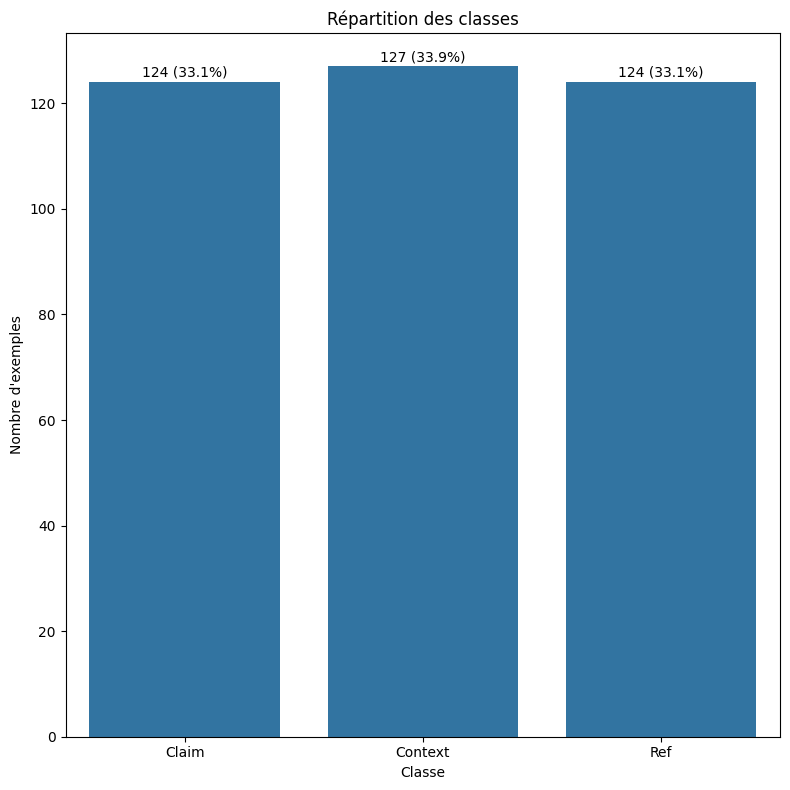

In [10]:
plt.figure(figsize=(8, 8))

counts = y.value_counts()
print(counts)
ax = sns.countplot(x=y)

for i in range(3):
    percentage = (counts[i] / len(df)) * 100
    ax.text(i, counts[i] + 1, f"{counts[i]} ({percentage:.1f}%)", ha='center')

plt.title("Répartition des classes")
plt.xlabel("Classe")
plt.xticks([0,1,2],["Claim","Context","Ref"])
plt.ylabel("Nombre d'exemples")
plt.tight_layout()
plt.show()


ℹ️  Evaluation de Régression Logistique avec TF-IDF
ℹ️  Evaluation de Régression Logistique avec Bag of words
ℹ️  Evaluation de Naive Bayes avec TF-IDF
ℹ️  Evaluation de Naive Bayes avec Bag of words
ℹ️  Evaluation de SVM Linéaire avec TF-IDF
ℹ️  Evaluation de SVM Linéaire avec Bag of words
ℹ️  Evaluation de Random Forest avec TF-IDF
ℹ️  Evaluation de Random Forest avec Bag of words
ℹ️  Evaluation de Decision Tree avec TF-IDF
ℹ️  Evaluation de Decision Tree avec Bag of words
ℹ️  Evaluation de KNN avec TF-IDF
ℹ️  Evaluation de KNN avec Bag of words
ℹ️  Evaluation de xgboost avec TF-IDF
ℹ️  Evaluation de xgboost avec Bag of words


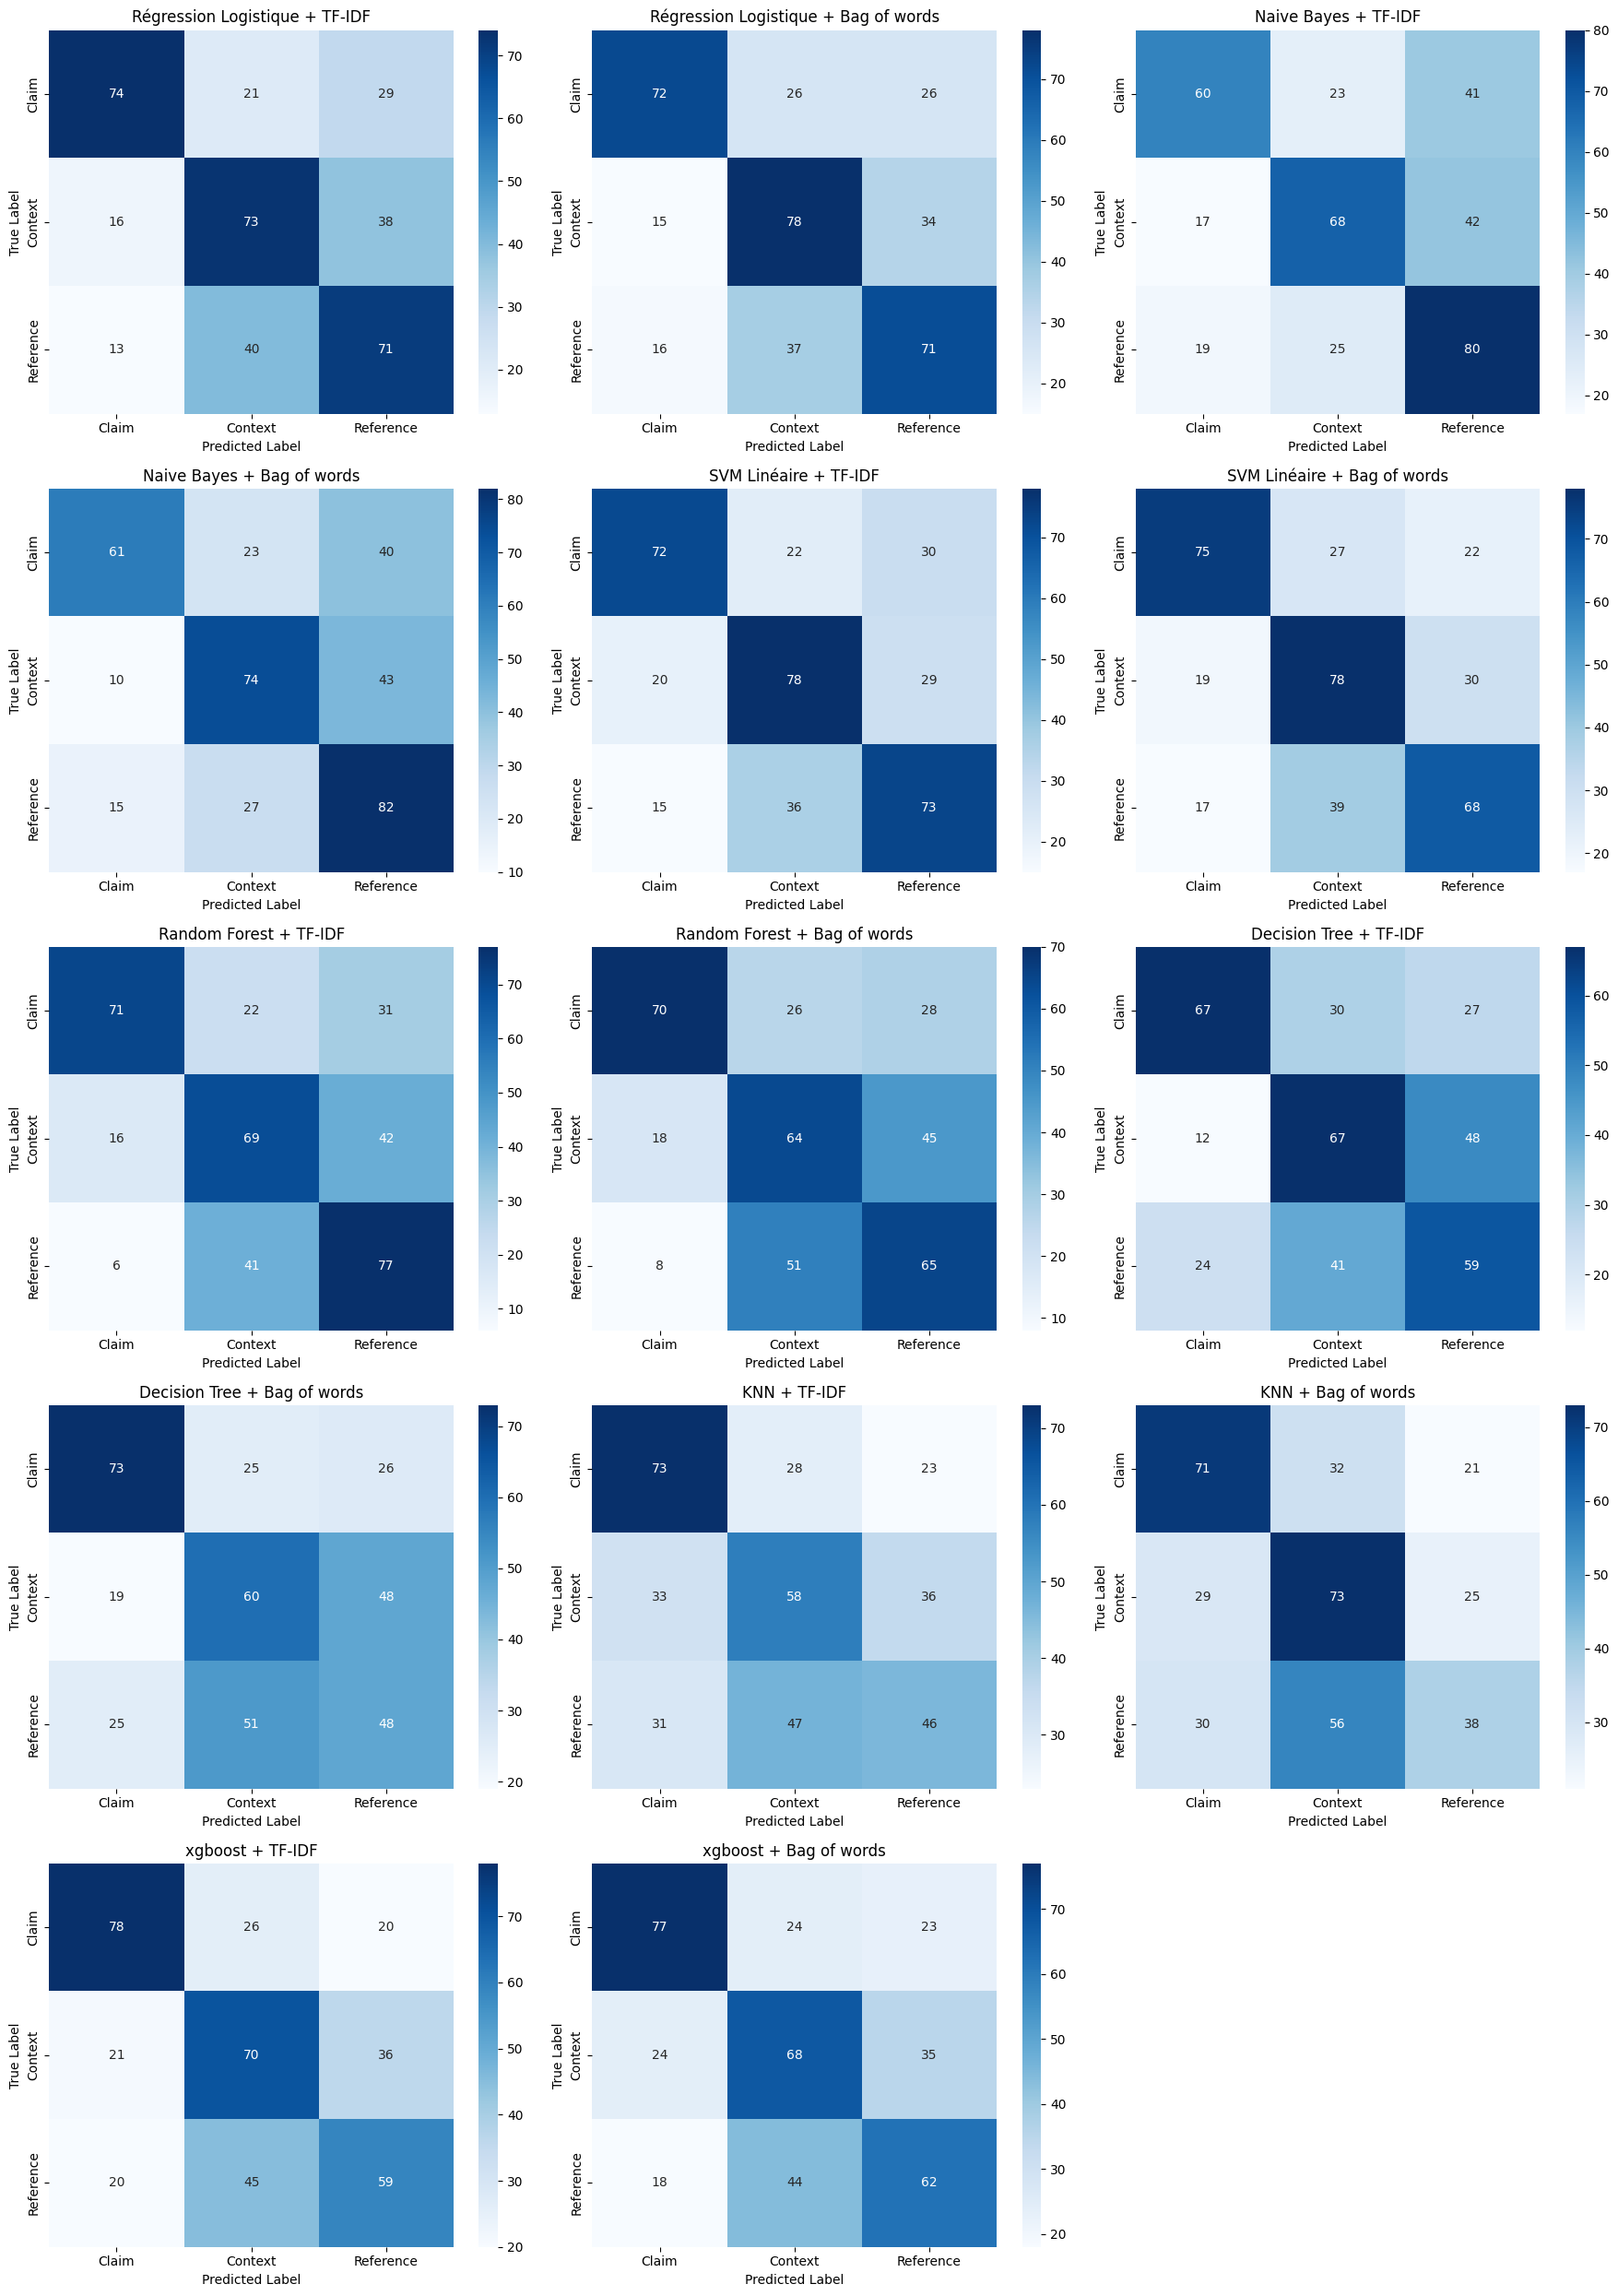

,Classifier,Vectorizer,F1 Mean,F1 Std
4,SVM Linéaire,TF-IDF,0.594,0.068
5,SVM Linéaire,Bag of words,0.588,0.048
1,Régression Logistique,Bag of words,0.587,0.050
0,Régression Logistique,TF-IDF,0.582,0.041
6,Random Forest,TF-IDF,0.582,0.024
3,Naive Bayes,Bag of words,0.578,0.068
13,xgboost,Bag of words,0.553,0.038
2,Naive Bayes,TF-IDF,0.552,0.058
12,xgboost,TF-IDF,0.552,0.058
7,Random Forest,Bag of words,0.536,0.023


In [11]:
import utils.evaluation_classifiers as evaluation_classifiers
importlib.reload(evaluation_classifiers)

evaluator = evaluation_classifiers.ClassifierEvaluation(X, y, KeywordFeatures(15), config, x_ticks)
results, classement_df = evaluator.evaluate()
classement_df.head(20)

# Le choix de mes Classifiers

1. SVM Linéaire & TF-IDF / Bag of words
2. Régression Logistique & TF-IDF / Bag of word
3. Random Forest & TF-IDF

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=config.random_state, test_size=config.test_ratio)
X_train.head()

print(f"Nous avons {X_train.shape[0]} tweets d'entrainements et {X_test.shape[0]} de test")

Nous avons 300 tweets d'entrainements et 75 de test


#### définitions de fonctions

In [13]:
ngram_options = {
	"unigram": (1, 1),
	"bigram": (1, 2),
	"trigram": (1, 3),
	"quadrugram": (1, 4)
}
numerical_cols = X_train.select_dtypes(include='number').columns.tolist()

text_col = "text"

In [14]:
def visualize_data_with_pca(X_test, y_test, pipeline, title="PCA des données", n_components = 2):
	"""
	Visualise les données transformées avec PCA et colore par classe
	"""
	# 1. Transformer les données avec le préprocesseur du pipeline
	preprocessor = pipeline.named_steps['preprocessor']
	X_transformed = preprocessor.transform(X_test)
	
	# Si la matrice est sparse, la convertir en dense
	if hasattr(X_transformed, "toarray"):
		X_dense = X_transformed.toarray()
	else:
		X_dense = X_transformed
	
	# 2. Appliquer PCA pour réduire à 2 dimensions
	pca = PCA(n_components=n_components)
	X_pca = pca.fit_transform(X_dense)
	
	# 3. Créer un DataFrame pour la visualisation
	df_plot = pd.DataFrame({
		'PC1': X_pca[:, 0],
		'PC2': X_pca[:, 1],
		'Class': y_test.values
	})
	
	# 4. Visualiser avec un scatter plot
	plt.figure(figsize=(10, 8))
	sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Class', 
				   palette={0: "red", 1: "blue"},s=60)
	
	# 5. Ajouter des informations sur la variance expliquée
	explained_var = pca.explained_variance_ratio_
	plt.xlabel(f'PC1 ({explained_var[0]:.2%} variance expliquée)')
	plt.ylabel(f'PC2 ({explained_var[1]:.2%} variance expliquée)')
	plt.title(f'{title}\nVariance totale expliquée: {sum(explained_var):.2%}')
	
	# 6. Ajouter une légende
	plt.legend(title="Classe", labels=["Non-scientifique", "Scientifique"])
	
	plt.grid(True, linestyle='--', alpha=0.7)
	plt.tight_layout()
	plt.plot()

	return X_pca

from sklearn.utils import resample

def get_score(pipeline, n_iterations=100):
    f1_scores = []
    
    for i in range(n_iterations):
        indices = resample(range(len(X_test)), replace=True, n_samples=len(X_test))
        X_boot = X_test.iloc[indices] if hasattr(X_test, 'iloc') else X_test[indices]
        y_boot = y_test.iloc[indices] if hasattr(y_test, 'iloc') else y_test[indices]

        y_pred = pipeline.predict(X_boot)
        f1 = f1_score(y_boot, y_pred, average='macro')
        f1_scores.append(f1)
    
    f1_mean = np.mean(f1_scores)
    f1_std = np.std(f1_scores)
    
    print(f"✅ F1-score (bootstrap sur test, {n_iterations} itérations): {f1_mean:.3f} ± {f1_std:.3f}")
    return f1_mean, f1_std

def get_vectorizer(vectorizer_type, ngram_key, min_df, max_features):
	if vectorizer_type == "tfidf":
		return TfidfVectorizer(
			ngram_range=ngram_options[ngram_key],
			min_df=min_df,
			max_features=max_features
		)
	return CountVectorizer(
			ngram_range=ngram_options[ngram_key],
			min_df=min_df,
			max_features=max_features
		)

def get_trial_score(classifier, vectorizer, n_keywords, scaling = True):
	preprocessor = ColumnTransformer(
		transformers=[
			("text", vectorizer, "text"),
			("num", StandardScaler() if scaling else "passthrough", numerical_cols)
		]
	)
	
	pipeline = Pipeline([
		("keywords", KeywordFeatures(n_keywords)),
		("preprocessor", preprocessor),
		("classifier", classifier)
	])

	kfold = KFold(n_splits=3, shuffle=True, random_state=config.random_state)
	return  cross_val_score(pipeline, X=X_train, y=y_train, cv=kfold, scoring='f1_macro').mean()


def get_pipeline(model, classifier, scaler = True):
	vectorizer = model.get_vectorizer()
	numerical_cols = X_train.select_dtypes(include='number').columns.tolist()

	
	preprocessor = ColumnTransformer(
		transformers=[
			("text", vectorizer, text_col),
			("num", StandardScaler() if scaler else "passthrough", numerical_cols)
		]
	)

	return Pipeline([
		("keywords", KeywordFeatures(model.get_config("n_keywords"))),
		("preprocessor", preprocessor),
		("classifier", classifier)
	])

#### SVM Linéaire & TF-IDF / Bag of words

In [27]:
def objective(trial):
	C = trial.suggest_float("C", 1e-1, 10, log=True)
	penalty = trial.suggest_categorical("penalty", ["l2"])
	loss = trial.suggest_categorical("loss", ["squared_hinge"])
	
	vectorizer_type = trial.suggest_categorical("vectorizer_type", ["tfidf", "bow"])
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 10)
	max_features = trial.suggest_int("max_features", 1000, 20000, step=1000)

	n_keywords = trial.suggest_int("n_keywords", 10, 30, step=5)

	vectorizer = get_vectorizer(vectorizer_type, ngram_key, min_df, max_features)
	classifier = LinearSVC(
        C=C,
        penalty=penalty,
        loss=loss,
        dual=True,
        random_state=config.random_state,
        max_iter=40_000
    )

	return get_trial_score(classifier, vectorizer, n_keywords, scaling=True)


study = optuna.create_study(direction="maximize")

[I 2025-05-06 20:55:56,458] A new study created in memory with name: no-name-66c61034-4d19-4bfa-990e-4ee2e4399c62


In [29]:
study.optimize(objective, n_trials=60)

print("Best f1_macro:", study.best_value)
print("Best params:", study.best_params)

config.save_model("SVM_Lineaire", study.best_params)

[I 2025-05-06 20:56:40,060] Trial 60 finished with value: 0.5832879455481644 and parameters: {'C': 8.82248816645232, 'penalty': 'l2', 'loss': 'squared_hinge', 'vectorizer_type': 'tfidf', 'ngram_range': 'unigram', 'min_df': 2, 'max_features': 11000, 'n_keywords': 30}. Best is trial 10 with value: 0.6471612886442797.
[I 2025-05-06 20:56:40,538] Trial 61 finished with value: 0.6471612886442797 and parameters: {'C': 9.927478130601374, 'penalty': 'l2', 'loss': 'squared_hinge', 'vectorizer_type': 'tfidf', 'ngram_range': 'unigram', 'min_df': 1, 'max_features': 12000, 'n_keywords': 30}. Best is trial 10 with value: 0.6471612886442797.
[I 2025-05-06 20:56:41,063] Trial 62 finished with value: 0.6471612886442797 and parameters: {'C': 7.526844180442914, 'penalty': 'l2', 'loss': 'squared_hinge', 'vectorizer_type': 'tfidf', 'ngram_range': 'unigram', 'min_df': 1, 'max_features': 12000, 'n_keywords': 30}. Best is trial 10 with value: 0.6471612886442797.
[I 2025-05-06 20:56:41,538] Trial 63 finished w

Best f1_macro: 0.6471612886442797
Best params: {'C': 9.89794256204728, 'penalty': 'l2', 'loss': 'squared_hinge', 'vectorizer_type': 'tfidf', 'ngram_range': 'unigram', 'min_df': 1, 'max_features': 14000, 'n_keywords': 30}
✅  Model (SVM_Lineaire) saved in config file


✅ F1-score (bootstrap sur test, 100 itérations): 0.617 ± 0.057


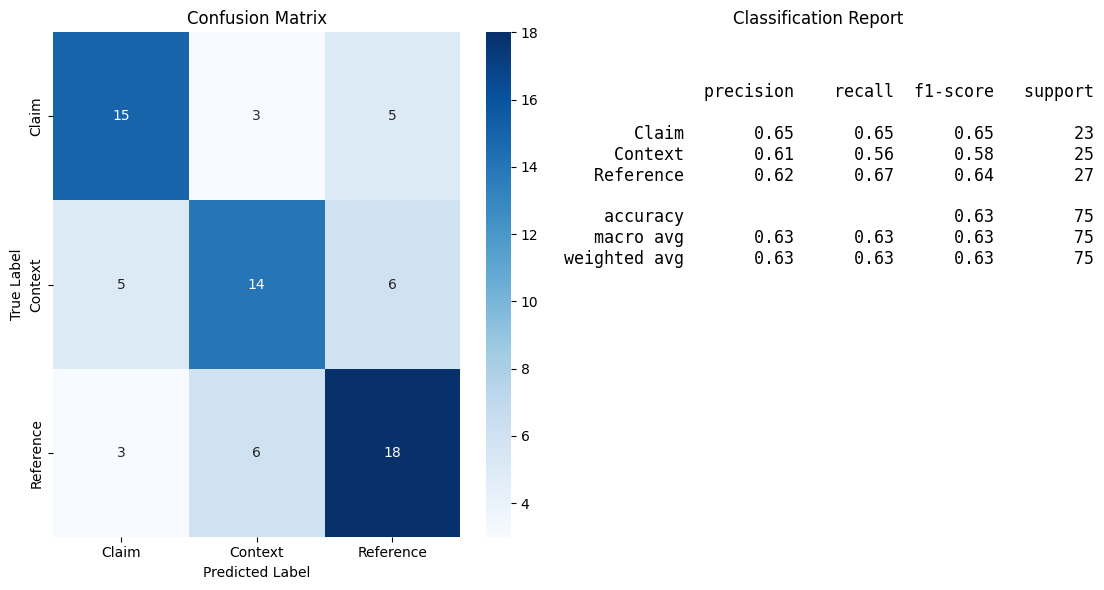

✅ Results saved to: ../results/Step3/SVM_Lineaire


In [15]:
model = config.get_model("SVM_Lineaire")

classifier = LinearSVC(
        C=model.get_config("C"),
        penalty=model.get_config("penalty"),
        loss=model.get_config("loss"),
        dual=True,
        random_state=config.random_state,
        max_iter=40_000
    )


pipeline_Xboost = get_pipeline(model, classifier)

pipeline_Xboost.fit(X_train, y_train)

y_pred = pipeline_Xboost.predict(X_test)

f1_m, f1_std = get_score(pipeline_Xboost)
fig = display_result(y_pred, y_test, x_ticks)

save_result(
	title=f"Rapport du {model.name}",
    description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
    fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, model.name),
	static_dir = config.static_dir
)


Ce modèle à des soucis d'itération et ne converge pas tout le temps, il y a beaucoup de souci de stabilité..

#### Régression Logistique & TF-IDF / Bag of word

In [35]:
def objective(trial):
	vectorizer_type = trial.suggest_categorical("vectorizer_type", ["tfidf", "bow"])
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 6)
	max_features = trial.suggest_int("max_features", 1000, 20000, step=1000)

	n_keywords = trial.suggest_int("n_keywords", 0, 30, step=5)
	
	# Hyperparamètres Logistic Regression
	C = trial.suggest_float("C", 1e-3, 100.0, log=True)
	penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
	solver = trial.suggest_categorical("solver", ["liblinear", "saga"])

	if penalty == "l1" and solver not in ["liblinear", "saga"]:
		raise optuna.exceptions.TrialPruned()

	if penalty == "l2" and solver not in ["liblinear", "saga"]:
		raise optuna.exceptions.TrialPruned()
	
	classifier = LogisticRegression(
		C=C,
		penalty=penalty,
		solver=solver,
		random_state=config.random_state,
		class_weight='balanced',
		max_iter=5000
	)
	vectorizer = get_vectorizer(vectorizer_type, ngram_key, min_df, max_features)

	return get_trial_score(classifier, vectorizer, n_keywords, scaling=True)

study = optuna.create_study(direction="maximize")

[I 2025-05-06 20:59:32,772] A new study created in memory with name: no-name-37071044-9b48-4ca7-af1d-4d22fac0e128


In [38]:
study.optimize(objective, n_trials=60)

print("Best f1_macro:", study.best_value)
print("Best params:", study.best_params)

config.save_model("Regression logistique", study.best_params)

[I 2025-05-06 21:02:09,593] Trial 60 finished with value: 0.5650649985237255 and parameters: {'vectorizer_type': 'tfidf', 'ngram_range': 'trigram', 'min_df': 1, 'max_features': 9000, 'n_keywords': 15, 'C': 37.74468632767033, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 33 with value: 0.6149416239912636.
[I 2025-05-06 21:02:10,638] Trial 61 finished with value: 0.614243675336914 and parameters: {'vectorizer_type': 'tfidf', 'ngram_range': 'trigram', 'min_df': 2, 'max_features': 9000, 'n_keywords': 20, 'C': 62.58884804506005, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 33 with value: 0.6149416239912636.
[I 2025-05-06 21:02:11,763] Trial 62 finished with value: 0.614243675336914 and parameters: {'vectorizer_type': 'tfidf', 'ngram_range': 'trigram', 'min_df': 2, 'max_features': 10000, 'n_keywords': 20, 'C': 70.57131359829458, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 33 with value: 0.6149416239912636.
[I 2025-05-06 21:02:12,804] Trial 63 finished with value: 0.61424367533

Best f1_macro: 0.6237152229142998
Best params: {'vectorizer_type': 'tfidf', 'ngram_range': 'trigram', 'min_df': 2, 'max_features': 14000, 'n_keywords': 10, 'C': 12.651371551861654, 'penalty': 'l2', 'solver': 'saga'}
✅  Model (Regression logistique) saved in config file


✅ F1-score (bootstrap sur test, 100 itérations): 0.633 ± 0.059


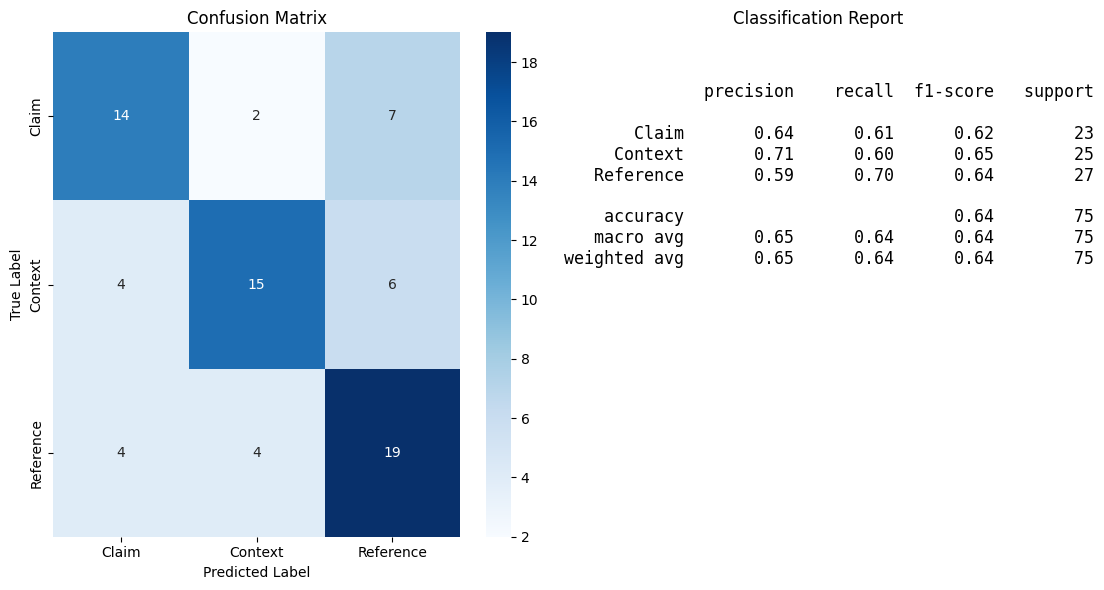

✅ Results saved to: ../results/Step3/Regression logistique


In [19]:
model = config.get_model("Regression logistique")
classifier = LogisticRegression(
        C = model.get_config("C"),
		penalty = model.get_config("penalty"),
        solver = model.get_config("solver"),
        class_weight = "balanced",
        random_state = config.random_state,
        max_iter = 4000
    )

pipeline_RL = get_pipeline(model, classifier)

pipeline_RL.fit(X_train, y_train)
y_pred = pipeline_RL.predict(X_test)

f1_m, f1_std = get_score(pipeline_RL)
fig = display_result(y_pred, y_test, x_ticks)

save_result(
	title=f"Rapport du {model.name}",
    description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
    fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, model.name),
	static_dir = config.static_dir
)

#### Random Forest & TF-IDF

In [20]:
def objective(trial):
	# Hyperparamètres texte
	vectorizer_type = trial.suggest_categorical("vectorizer_type", ["bow", "tfidf"])
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 10)
	max_features = trial.suggest_int("max_features", 1000, 20000, step=1000)

	# Hyperparamètres Random Forest
	n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
	max_depth = trial.suggest_int("max_depth", 5, 50)
	min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
	min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)

	bootstrap = trial.suggest_categorical("bootstrap", [True, False])
	max_features_model = trial.suggest_categorical("max_features_model", ['sqrt', 'log2', None])

	n_keywords = trial.suggest_int("n_keywords", 10, 30, step=5)
	
	classifier = RandomForestClassifier(
		n_estimators=n_estimators,
		max_depth=max_depth,
		min_samples_split=min_samples_split,
		min_samples_leaf=min_samples_leaf,
		random_state=config.random_state,
		max_features= max_features_model,
		bootstrap = bootstrap,
		class_weight='balanced'
	)

	vectorizer = get_vectorizer(vectorizer_type, ngram_key, min_df, max_features)
	return get_trial_score(classifier, vectorizer, n_keywords, scaling=False)

study = optuna.create_study(direction="maximize")


[I 2025-05-06 21:21:51,156] A new study created in memory with name: no-name-93326166-b669-47c8-b774-5c45019e7235


In [21]:
study.optimize(objective, n_trials=50)

print("Best f1_macro:", study.best_value)
print("Best params:", study.best_params)

config.save_model("Random Forest", study.best_params)

[I 2025-05-06 21:22:02,370] Trial 0 finished with value: 0.5895707202873589 and parameters: {'vectorizer_type': 'bow', 'ngram_range': 'unigram', 'min_df': 4, 'max_features': 6000, 'n_estimators': 700, 'max_depth': 39, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features_model': 'sqrt', 'n_keywords': 25}. Best is trial 0 with value: 0.5895707202873589.
[I 2025-05-06 21:22:08,697] Trial 1 finished with value: 0.5572995648495337 and parameters: {'vectorizer_type': 'tfidf', 'ngram_range': 'bigram', 'min_df': 5, 'max_features': 18000, 'n_estimators': 700, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features_model': None, 'n_keywords': 20}. Best is trial 0 with value: 0.5895707202873589.
[I 2025-05-06 21:22:11,950] Trial 2 finished with value: 0.5863990144228007 and parameters: {'vectorizer_type': 'bow', 'ngram_range': 'unigram', 'min_df': 6, 'max_features': 14000, 'n_estimators': 700, 'max_depth': 24, 'min_samples_split'

Best f1_macro: 0.6034189475254682
Best params: {'vectorizer_type': 'bow', 'ngram_range': 'unigram', 'min_df': 2, 'max_features': 11000, 'n_estimators': 900, 'max_depth': 48, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features_model': 'sqrt', 'n_keywords': 15}
✅  Model (Random Forest) saved in config file


✅ F1-score (bootstrap sur test, 100 itérations): 0.606 ± 0.057


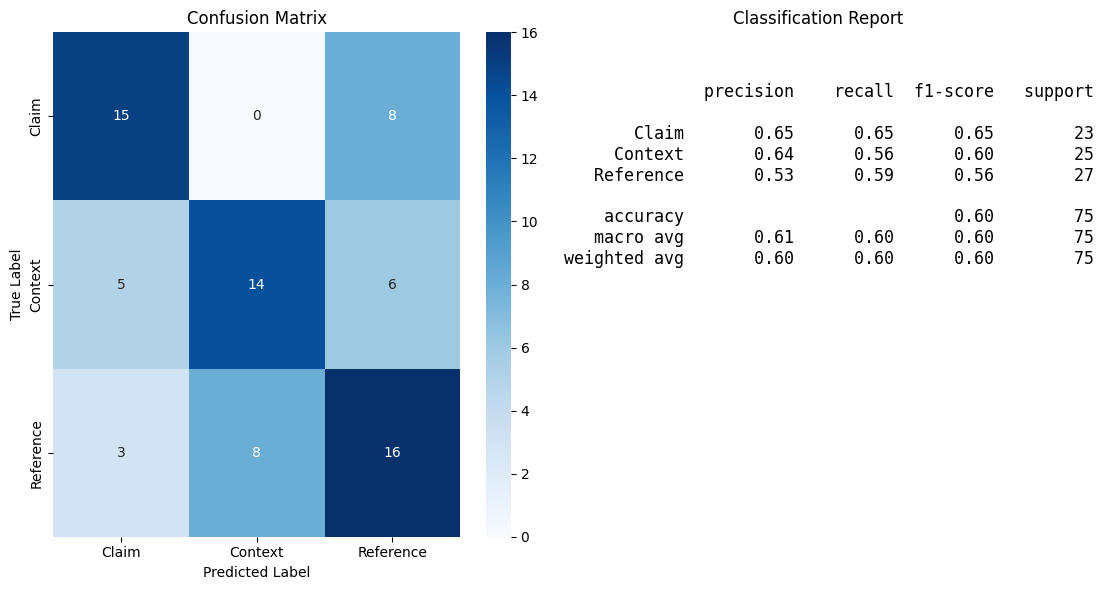

✅ Results saved to: ../results/Step3/Random Forest


In [22]:
model = config.get_model("Random Forest")
classifier = RandomForestClassifier(
		n_estimators = model.get_config("n_estimators"),
		max_depth = model.get_config("max_depth"),
		min_samples_split = model.get_config("min_samples_split"),
		min_samples_leaf = model.get_config("min_samples_leaf"),
		bootstrap = model.get_config("bootstrap"),
		max_features = model.get_config("max_features_model"),
		random_state = config.random_state,
		class_weight='balanced'
	)

pipeline_RF = get_pipeline(model, classifier)

pipeline_RF.fit(X_train, y_train)
y_pred = pipeline_RF.predict(X_test)

f1_m, f1_std = get_score(pipeline_RF)
fig = display_result(y_pred, y_test, x_ticks)

save_result(
	title=f"Rapport du {model.name}",
    description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
    fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, model.name),
	static_dir = config.static_dir
)